# Pairs Daily Analysis

Explore gold-layer co-movement data stored in the `pairs_daily` table. The notebook
uses Amazon Athena (via boto3) to pull metrics, then plots key analytics:

1. Histogram of the Geo-Temporal Overlap (GTO) score distribution.
2. Number of days individual pairs are observed together.
3. Inspection of GTO values to surface a potential inflection point that separates
   routine overlap from likely coordinated movement.

In [1]:
import json
import os
import time

from pathlib import Path

import boto3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")

# ---------------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------------
DATABASE = os.environ.get("PAIRS_DATABASE", "knap_ais")
TABLE = os.environ.get("PAIRS_TABLE", "pairs_daily")
ATHENA_OUTPUT = os.environ.get("ATHENA_STAGING_DIR") or "s3://knap-ais/athena-results/"
WORKGROUP = os.environ.get("ATHENA_WORKGROUP", "primary")
REGION = os.environ.get("AWS_REGION", "us-east-1")

print(f"Querying {DATABASE}.{TABLE} in {REGION}, workgroup={WORKGROUP}")

Querying knap_ais.pairs_daily in us-east-1, workgroup=primary


In [2]:
athena = boto3.client("athena", region_name=REGION)

def run_athena_query(sql: str, *, poll_seconds: float = 2.0) -> pd.DataFrame:
    """Execute an Athena query and return the results as a DataFrame."""
    response = athena.start_query_execution(
        QueryString=sql,
        QueryExecutionContext={"Database": DATABASE},
        WorkGroup=WORKGROUP,
        ResultConfiguration={"OutputLocation": ATHENA_OUTPUT},
    )
    execution_id = response["QueryExecutionId"]

    while True:
        status = athena.get_query_execution(QueryExecutionId=execution_id)
        state = status["QueryExecution"]["Status"]["State"]
        if state in {"SUCCEEDED", "FAILED", "CANCELLED"}:
            break
        time.sleep(poll_seconds)

    if state != "SUCCEEDED":
        reason = status["QueryExecution"]["Status"].get("StateChangeReason", "Unknown error")
        raise RuntimeError(f"Athena query failed: {state} -> {reason}")

    result = athena.get_query_results(QueryExecutionId=execution_id)

    rows = result["ResultSet"]["Rows"]
    headers = [col["VarCharValue"] for col in rows[0]["Data"]]
    values = []
    for row in rows[1:]:
        values.append([col.get("VarCharValue") for col in row["Data"]])

    # Handle pagination for large result sets.
    next_token = result.get("NextToken")
    while next_token:
        result = athena.get_query_results(QueryExecutionId=execution_id, NextToken=next_token)
        for row in result["ResultSet"]["Rows"]:
            values.append([col.get("VarCharValue") for col in row["Data"]])
        next_token = result.get("NextToken")

    frame = pd.DataFrame(values, columns=headers)
    return frame

In [3]:
SQL_SAMPLE = f"""
SELECT
  uid_a,
  uid_b,
  day_date,
  gto,
  hT,
  gT
FROM {TABLE}
WHERE day_date BETWEEN DATE '2025-01-01' AND DATE '2025-01-31'
LIMIT 200000
"""

pairs = run_athena_query(SQL_SAMPLE)
pairs = pairs.astype({
    "day_date": "datetime64[ns]",
    "gto": "float64",
    "hT": "int64",
    "gT": "int64",
})
pairs.head()

,uid_a,uid_b,day_date,gto,hT,gT
0,366961460,538009928,2025-01-19,0.118590,2,2
1,367688580,368070420,2025-01-19,0.429167,11,2
2,229000821,311000660,2025-01-19,0.291667,2,2
3,368247290,368286810,2025-01-19,0.312500,3,2
4,366970770,538006808,2025-01-19,0.291667,8,2


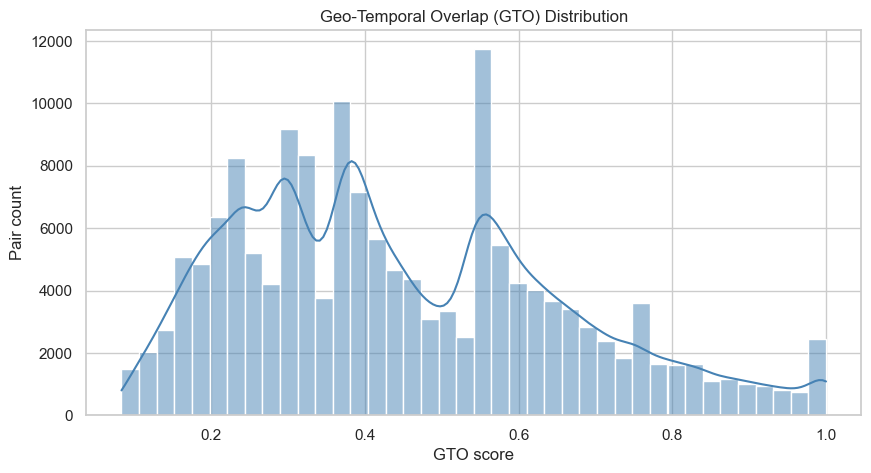

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(pairs["gto"], bins=40, kde=True, color="steelblue")
plt.title("Geo-Temporal Overlap (GTO) Distribution")
plt.xlabel("GTO score")
plt.ylabel("Pair count")
plt.show()


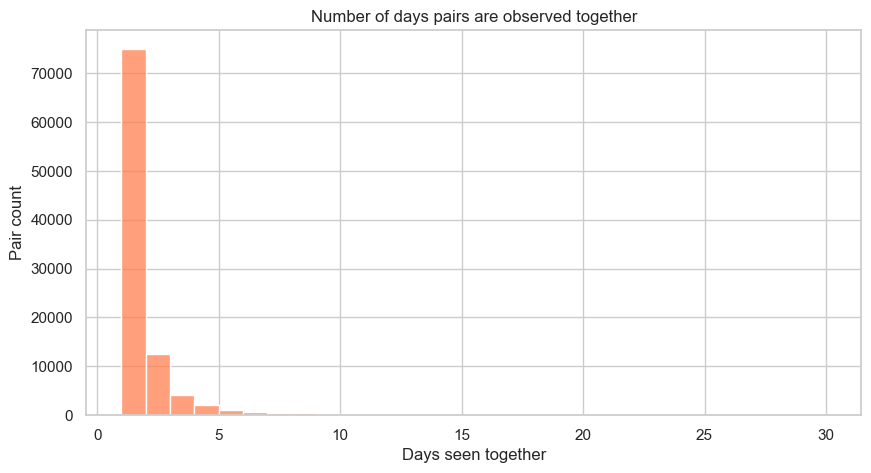

,uid_a,uid_b,days_seen,max_gto
50191,367171010,367702510,30,0.937500
7494,316028554,316042365,30,0.937500
40565,367011510,367378120,30,0.833333
55071,367352630,368061910,29,0.854167
52265,367311510,367515330,29,0.937500


In [5]:
days_together = (
    pairs.groupby(["uid_a", "uid_b"], as_index=False)
    .agg(days_seen=("day_date", "nunique"), max_gto=("gto", "max"))
)

plt.figure(figsize=(10, 5))
sns.histplot(days_together["days_seen"], binwidth=1, color="coral")
plt.title("Number of days pairs are observed together")
plt.xlabel("Days seen together")
plt.ylabel("Pair count")
plt.show()

days_together.sort_values("days_seen", ascending=False).head()

,gto
quantile,
0.50,0.408333
0.75,0.583333
0.90,0.750000
0.95,0.854167
0.99,1.000000


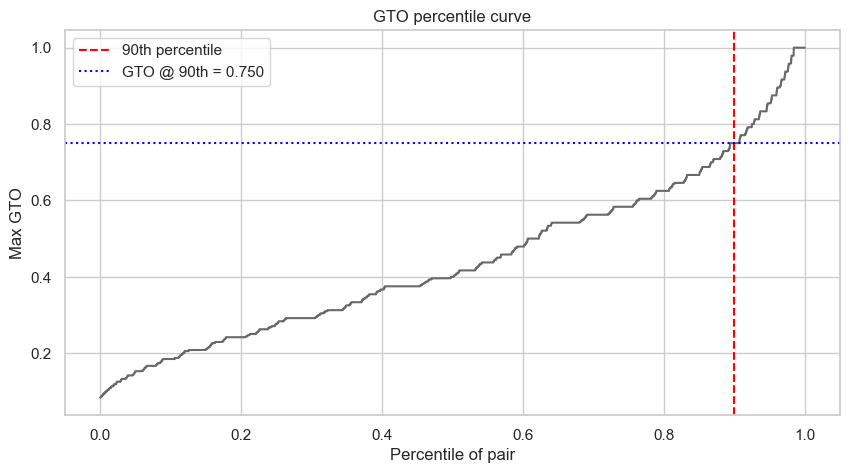

A potential inflection point is around the 90th percentile (GTO ≈ 0.750), which often marks recurring co-movement beyond incidental overlap.


In [6]:
quantiles = pairs["gto"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename_axis("quantile")
display(quantiles.to_frame("gto"))

sorted_gto = days_together.sort_values("max_gto")
sorted_gto["rank"] = range(1, len(sorted_gto) + 1)
sorted_gto["pct_rank"] = sorted_gto["rank"] / len(sorted_gto)

plt.figure(figsize=(10, 5))
plt.plot(sorted_gto["pct_rank"], sorted_gto["max_gto"], color="dimgray")
plt.axvline(0.9, color="red", linestyle="--", label="90th percentile")
plt.axhline(quantiles.loc[0.9], color="blue", linestyle=":", label="GTO @ 90th = {:.3f}".format(quantiles.loc[0.9]))
plt.xlabel("Percentile of pair")
plt.ylabel("Max GTO")
plt.title("GTO percentile curve")
plt.legend()
plt.show()

print(
    "A potential inflection point is around the 90th percentile (GTO ≈ {:.3f}),".format(quantiles.loc[0.9]),
    "which often marks recurring co-movement beyond incidental overlap."
)

## Aggregate metrics for `pairs_total`

The snippet below mirrors the `sql/gold/create_pairs_total.sql` CTAS by summarising
the sampled data with pandas. Adjust the threshold as needed before writing the
results back to S3 or Athena.

In [ ]:
GTO_THRESHOLD = 0.75

pairs_total = (
    pairs.groupby(["uid_a", "uid_b"], as_index=False)
    .agg(
        total_days_observed=("day_date", "nunique"),
        days_with_gto_above_threshold=("gto", lambda s: (s >= GTO_THRESHOLD).sum()),
        max_gto=("gto", "max"),
        min_gto=("gto", "min"),
        avg_gto=("gto", "mean"),
        median_gto=("gto", "median"),
        avg_hT=("hT", "mean"),
        median_hT=("hT", "median"),
        avg_gT=("gT", "mean"),
        median_gT=("gT", "median"),
    )
)

pairs_total.sort_values("days_with_gto_above_threshold", ascending=False).head()

,uid_a,uid_b,total_days_observed,days_with_gto_above_threshold,max_gto,min_gto,avg_gto,median_gto,avg_hT,median_hT,avg_gT,median_gT
37602,367000110,367000120,26,26,1.0,0.884615,0.960576,0.958333,21.615385,22.0,2.000000,2.0
56332,367369550,367515760,27,25,1.0,0.687500,0.902006,0.937500,20.777778,21.0,3.148148,3.0
84728,367750780,367750940,27,25,1.0,0.583333,0.909314,0.928571,8.037037,7.0,3.629630,4.0
61725,367438690,368127980,26,25,1.0,0.729167,0.936177,0.968750,21.192308,22.0,2.653846,3.0
83440,367719610,367748030,26,25,1.0,0.718750,0.891472,0.935417,18.423077,20.0,2.384615,2.0


In [ ]:
quantiles = pairs_total["avg_gT"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename_axis("quantile")
display(quantiles.to_frame("avg_gT"))

print('this is a strong sign we should have used a higher resolution h3')


,avg_gT
quantile,
0.50,2.0
0.75,2.0
0.90,2.5
0.95,3.0
0.99,4.0


this is a strong sign we should have used a higher resolution h3


In [ ]:
filtered_pairs = pairs_total.query("days_with_gto_above_threshold < 20")
filtered_pairs.sort_values("days_with_gto_above_threshold", ascending=False).head(20)


,uid_a,uid_b,total_days_observed,days_with_gto_above_threshold,max_gto,min_gto,avg_gto,median_gto,avg_hT,median_hT,avg_gT,median_gT
71871,367560890,368020480,26,19,0.937500,0.541667,0.787395,0.791667,13.384615,14.0,2.038462,2.0
73771,367583670,367767850,26,19,0.916667,0.619048,0.777816,0.781250,13.307692,13.5,2.076923,2.0
6953,316014621,316028554,25,19,0.937500,0.687500,0.795833,0.791667,14.200000,14.0,2.000000,2.0
30705,366969480,368068820,20,19,1.000000,0.687500,0.952385,0.978714,22.050000,22.0,2.550000,2.0
6334,316005623,316005651,19,19,1.000000,0.750000,0.950658,0.979167,21.631579,23.0,2.000000,2.0
7494,316028554,316042365,30,19,0.937500,0.645833,0.798611,0.791667,14.333333,14.0,2.000000,2.0
19264,366651000,366990560,20,19,1.000000,0.735294,0.939285,0.972222,15.100000,17.0,2.000000,2.0
20256,366772980,367608860,22,18,0.895833,0.645833,0.808712,0.833333,16.272727,16.5,2.000000,2.0
53435,367331070,367336580,18,18,1.000000,0.750000,0.870370,0.854167,21.777778,22.0,2.222222,2.0
69982,367534880,367749970,26,18,1.000000,0.520833,0.810897,0.833333,15.615385,16.0,2.115385,2.0


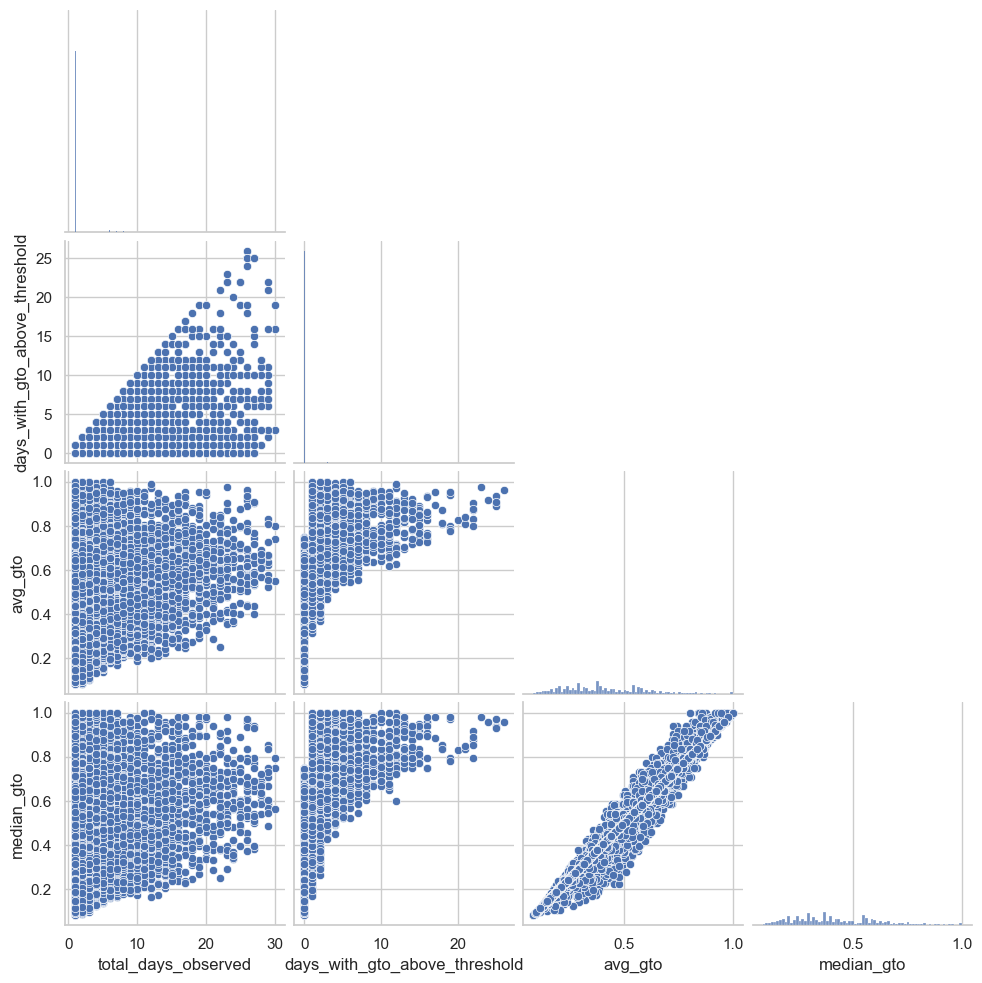

In [10]:
# lets look at pairs that arent always high but come together for short periods of time.

sns.pairplot(pairs_total[['total_days_observed','days_with_gto_above_threshold', 'avg_gto',
       'median_gto']], corner=True)

python apps/export_tracks_to_explore.py \
  --start 2025-01-01 \
  --stop  2025-01-31 \
  --mmsi 367761730 367761740 \
  --staging-dir s3://knap-ais/athena-results/ \
  --region us-east-1


367695890 368349280 are great examples of two MMSIs travling separately and then coming together and traveling together for several days.  The following charachteristics made it easy to identify: high hT and high gto over a several day period and then dropping back down below the threshold.

In [22]:
pairs_total.query('median_gT > 4').sort_values('median_gT')

,uid_a,uid_b,total_days_observed,days_with_gto_above_threshold,max_gto,min_gto,avg_gto,median_gto,avg_hT,median_hT,avg_gT,median_gT
81766,367695890,368349280,2,0,0.587500,0.352273,0.469886,0.469886,7.5,7.5,4.5,4.5
1958,243710112,243710120,2,0,0.428571,0.333333,0.380952,0.380952,4.5,4.5,4.5,4.5
66967,367505070,368349280,2,0,0.625000,0.303030,0.464015,0.464015,7.0,7.0,4.5,4.5
67264,367507080,367564470,2,0,0.333333,0.107955,0.220644,0.220644,5.0,5.0,4.5,4.5
67767,367511270,367547030,2,0,0.415064,0.402778,0.408921,0.408921,10.5,10.5,4.5,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...
5781,311807000,636013615,1,1,0.804924,0.804924,0.804924,0.804924,19.0,19.0,18.0,18.0
1522,235076276,636018882,1,1,0.766304,0.766304,0.766304,0.766304,18.0,18.0,18.0,18.0
74955,367598830,368205350,1,1,0.791667,0.791667,0.791667,0.791667,19.0,19.0,19.0,19.0
97738,477455500,538007465,1,1,0.914855,0.914855,0.914855,0.914855,22.0,22.0,21.0,21.0
